In [99]:
import numpy as np
import json
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import bcolz
from matplotlib import pyplot as plt
import itertools
import pandas as pd
%matplotlib inline

In [2]:
path = "./data/dogscats/"
#path = "./data/dogscats/sample/"

In [3]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 1. Adding a layer on top of vgg

In [4]:
#creating vgg model
keras.backend.set_image_dim_ordering('th')

def preprocess_data(x):
    vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    x = x - vgg_mean
    return x[:, ::-1]

def ConvBlock(model, num, filters):
    for i in range(num):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
def FCBlock(model, num):
    model.add(Dense(num, activation='relu'))
    model.add(Dropout(0.5))

In [69]:
model = Sequential()
model.add(Lambda(preprocess_data, input_shape=(3, 224, 224), output_shape=(3,224,224)))

ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())

FCBlock(model, 4096)
FCBlock(model, 4096)

model.add(Dense(1000, activation='softmax'))

path_to_models='http://files.fast.ai/models/'
fname = 'vgg16.h5'

f = get_file(fname, path_to_models+fname, cache_subdir='models')
model.load_weights(f)

In [6]:
#obtaining classes info
fname = 'imagenet_class_index.json'
fl = get_file(fname, path_to_models+fname, cache_subdir='models')
with open(fl) as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [7]:
#prepairing data
batch_size = 8
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'train', target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)
val_batches = gen.flow_from_directory(path+'valid', target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)

#batches = get_batches(path+"train", shuffle = True, batch_size = batch_size)
#val_batches = get_batches(path+"valid", shuffle = True, batch_size = batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
#one-hot encoding labels
train_classes = batches.classes
val_classes = val_batches.classes

oe = OneHotEncoder()
train_labels = np.array(oe.fit_transform(train_classes.reshape(-1,1)).todense())
val_labels = np.array(oe.fit_transform(val_classes.reshape(-1,1)).todense())

In [9]:
val_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [11]:
#tr_gen = gen.flow_from_directory(path+'train', target_size=(224,224), class_mode=None, shuffle=False, batch_size=8)
#train_data = np.concatenate([tr_gen.next() for i in range(tr_gen.nb_sample)])
#train_features = model.predict(train_data, batch_size = batch_size)

#val_gen = gen.flow_from_directory(path+'valid', target_size=(224,224), class_mode=None, shuffle=False, batch_size=1)
#val_data = np.concatenate([val_gen.next() for i in range(val_gen.nb_sample)])
#val_features = model.predict(val_data, batch_size = batch_size)

Found 23000 images belonging to 2 classes.


In [15]:
tr_gen = gen.flow_from_directory(path+'train', target_size=(224,224), class_mode=None, shuffle=False, batch_size=8)
train_features = model.predict_generator(tr_gen, val_samples = tr_gen.nb_sample)
val_gen = gen.flow_from_directory(path+'valid', target_size=(224,224), class_mode=None, shuffle=False, batch_size=8)
val_features = model.predict_generator(val_gen, val_samples = val_gen.nb_sample)

Found 2000 images belonging to 2 classes.


In [14]:
train_features.shape

(23000, 1000)

In [11]:
#saving and restoring features (playing with functions)
c = bcolz.carray(train_features, rootdir = path+"train_lastlayer_features.bc", mode="w")
c.flush()

train_features = bcolz.open(path+"train_lastlayer_features.bc")[:]

In [12]:
train_features.shape

(16, 1000)

In [16]:
lm = Sequential([Dense(2, activation = "softmax", input_shape=(1000,))])
lm.compile(optimizer = RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
lm.fit(train_features, train_labels, nb_epoch=3, batch_size = 8, validation_data = (val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 4s - loss: 0.1140 - acc: 0.9710 - val_loss: 0.1448 - val_acc: 0.9665
Epoch 2/3
23000/23000 [==============================] - 4s - loss: 0.1277 - acc: 0.9751 - val_loss: 0.1569 - val_acc: 0.9700
Epoch 3/3
23000/23000 [==============================] - 4s - loss: 0.1377 - acc: 0.9763 - val_loss: 0.1669 - val_acc: 0.9700


In [15]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


In [18]:
preds = lm.predict_classes(val_features, batch_size=batch_size)
#probs of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]

1944/2000 [============================>.] - ETA: 0s

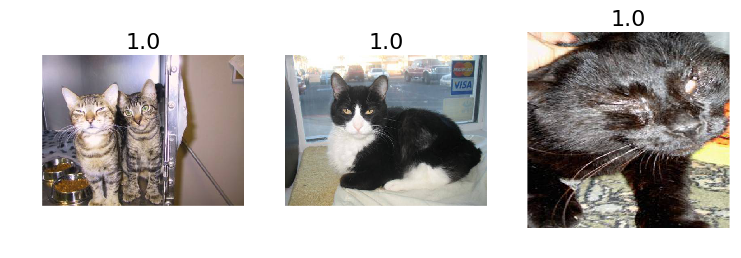

In [19]:
#the cats we are most confident about
n = 3
correct = np.where((preds == 0) & (val_labels[:,0]==1))[0]
filenames = val_batches.filenames
most_correct = np.argsort(probs[correct])[::-1][:n]
plots([image.load_img(path+'valid/'+filenames[i]) for i in correct[most_correct]], titles = probs[correct][most_correct])

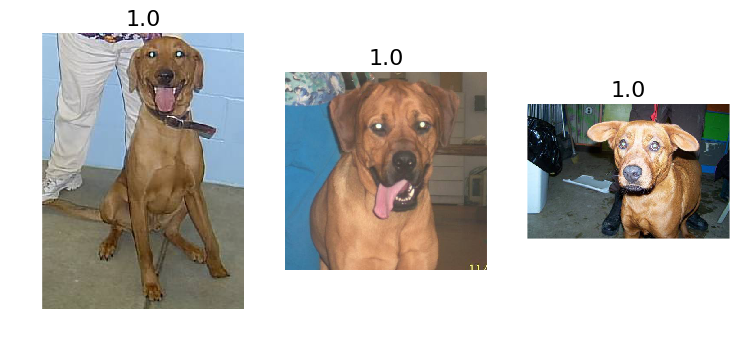

In [20]:
#the dogs we are most confident about
correct = np.where((preds == 1) & (val_labels[:,1]==1))[0]
filenames = val_batches.filenames
most_correct = np.argsort(probs[correct])[:n]
plots([image.load_img(path+'valid/'+filenames[i]) for i in correct[most_correct]], titles = 1-probs[correct][most_correct])

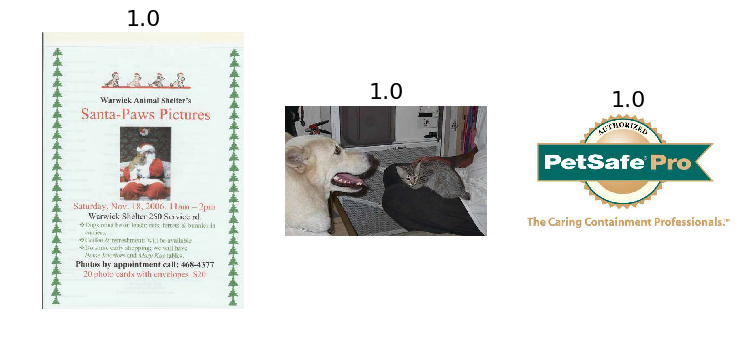

In [21]:
#cats we mistakenly classified as dogs
n = 3
incorrect = np.where((preds == 1) & (val_labels[:,0]==1))[0]
if len(incorrect) == 0:
    print("No incorrect dogs!")
else:
    filenames = val_batches.filenames
    most_incorrect = np.argsort(probs[incorrect])[:n]
    plots([image.load_img(path+'valid/'+filenames[i]) for i in incorrect[most_incorrect]], titles = 1-probs[incorrect][most_incorrect])

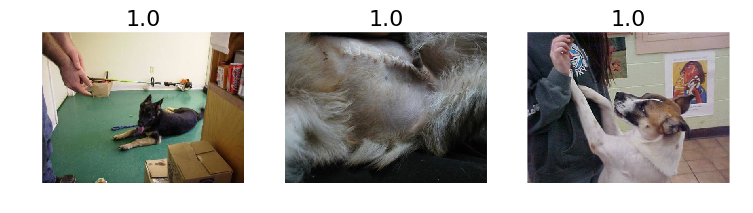

In [22]:
#dogs we mistakenly classified as cats
n = 3
incorrect = np.where((preds == 0) & (val_labels[:,1]==1))[0]
if len(incorrect) == 0:
    print("No incorrect cats!")
else:
    filenames = val_batches.filenames
    most_incorrect = np.argsort(probs[incorrect])[::-1][:n]
    plots([image.load_img(path+'valid/'+filenames[i]) for i in incorrect[most_incorrect]], titles = probs[incorrect][most_incorrect])

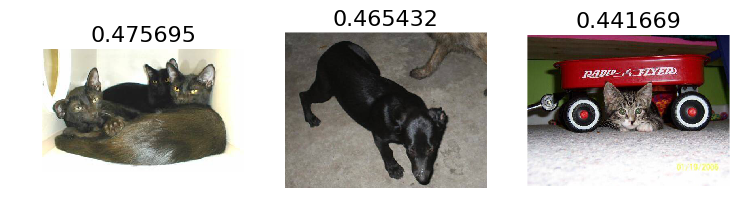

In [23]:
#most uncertain images
most_uncertain = np.argsort(np.abs(probs-0.5))[:n]
plots([image.load_img(path+'valid/'+filenames[i]) for i in most_uncertain], titles = probs[most_uncertain])

#### 2. Modifying and training the last layer (fine-tuning)

In [70]:
model.pop()
for layer in model.layers:
    layer.trainable = False

In [71]:
model.add(Dense(2, activation='softmax'))

In [72]:
batch_size = 8
gen = image.ImageDataGenerator()
tr_gen = gen.flow_from_directory(path+'train', target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=8)
val_gen = gen.flow_from_directory(path+'valid', target_size=(224,224), class_mode='categorical', shuffle=False, batch_size=8)

#batches = gen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
#val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [73]:
model.fit_generator(tr_gen, samples_per_epoch=tr_gen.nb_sample, nb_epoch=1, validation_data=val_gen, nb_val_samples=val_gen.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 626s - loss: 0.7093 - acc: 0.9548 - val_loss: 0.4161 - val_acc: 0.9735


In [74]:
model.evaluate_generator(val_gen, val_gen.nb_sample)

[0.41608130273379024, 0.97350000000000003]

In [38]:
val_gen = gen.flow_from_directory(path+'valid', target_size=(224,224), class_mode=None, shuffle=False, batch_size=1)
val_data = np.concatenate([val_gen.next() for i in range(val_gen.nb_sample)])
preds = model.predict_classes(val_data, batch_size=8)
probs = model.predict_proba(val_data, batch_size=8)[:,0]

Found 2000 images belonging to 2 classes.
2000/2000 [==============================] - 49s    


In [33]:
preds.shape

(2000, 2)

[[988  12]
 [ 40 960]]


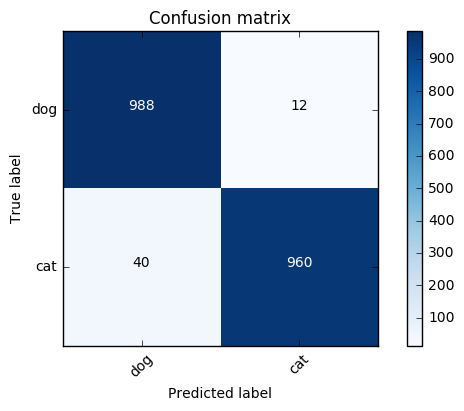

In [41]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat': 0, 'dog': 1})

### 3. Retraining more layers of vgg

In [75]:
#finetuning all dense layers
layers = model.layers
ind = 0
for i, layer in enumerate(layers):
    if type(layer) is Dense:
        ind = i
        break
for layer in layers[ind:]:
    layer.trainable = True

In [76]:
keras.backend.set_value(opt.lr, 0.01)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(tr_gen, samples_per_epoch=tr_gen.nb_sample, nb_epoch=1, validation_data=val_gen, nb_val_samples=val_gen.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 626s - loss: 0.4437 - acc: 0.9718 - val_loss: 0.4047 - val_acc: 0.9735


In [77]:
#retraining some of the conv layers
for layer in layers[12:]:
    layer.trainable = True
keras.backend.set_value(opt.lr, 0.001)
model.fit_generator(tr_gen, samples_per_epoch=tr_gen.nb_sample, nb_epoch=1, validation_data=val_gen, nb_val_samples=val_gen.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 627s - loss: 0.4524 - acc: 0.9715 - val_loss: 0.4076 - val_acc: 0.9735


In [86]:
test_gen = gen.flow_from_directory(path+'test', target_size=(224,224), class_mode=None, shuffle=False, batch_size=10)

Found 12500 images belonging to 1 classes.


In [88]:
preds = model.predict_generator(test_gen, val_samples=test_gen.nb_sample)

In [89]:
preds.shape

(12500, 2)

In [97]:
ids = map(lambda x: int(x.replace('test1/', '').replace('.jpg','')), test_gen.filenames)

In [109]:
df = pd.DataFrame({'id': ids, 'label': preds[:, 1]})

In [110]:
df.label = df.label.astype(int)

In [111]:
df.sort_values('id', inplace=True)

In [112]:
df.to_csv('predictions.csv', index=False)